In [103]:
import math
import pandas as pd
from datetime import datetime

In [104]:
user_ids = [1, 2, 4, 5, 6, 8, 10, 11, 12, 13, 15, 16, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 31, 32, 33, 34, 37, 38, 39, 40, 44, 45, 46, 47, 48]
len(user_ids)

35

In [105]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#add and preprocess data

In [106]:
db = '/content/drive/MyDrive/reliance/data_analysis_files+code/'

# add processed data at 50%/65%/75%/85%
duration = pd.read_csv(db+'bucket_gaze_duration_divided_by_fixation_total_0.75.csv', sep=',')
shift = pd.read_csv(db+'bucket_gaze_shift_0.75.csv', sep=',')
shift_origin = shift.copy()

# add processed data at 100%
total_features = pd.read_excel(db+'features.xlsx')
total_features = total_features.sort_values(by = ['User id', 'round'])
total_features = total_features.reset_index(drop=True)

In [107]:
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold or val <= -threshold:
                # Print the correlated features and the correlation value
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    return drops

In [108]:
#extract features from duration data
percent_duration_ai = duration.loc[(duration['location'] == 'AI')& (duration['bucket'] == 0)][['percent duration', 'User id', 'round']]
percent_duration_task = duration.loc[(duration['location'] == 'Task')& (duration['bucket'] == 0)][['percent duration', 'User id', 'round']]
percent_duration_user = duration.loc[(duration['location'] == 'User')& (duration['bucket'] == 0)][['percent duration', 'User id', 'round']]

#extract features from shift data
percent_shift_ai2task = shift.loc[(shift['shift'] == 'AI2Task') & (shift['bucket'] == 0)][['percent_shift', 'User id', 'round']]
percent_shift_ai2user = shift.loc[(shift['shift'] == 'AI2User') & (shift['bucket'] == 0)][['percent_shift', 'User id', 'round']]
percent_shift_task2user = shift.loc[(shift['shift'] == 'Task2User') & (shift['bucket'] == 0)][['percent_shift', 'User id', 'round']]
percent_shift_task2ai = shift.loc[(shift['shift'] == 'Task2AI') & (shift['bucket'] == 0)][['percent_shift', 'User id', 'round']] 
percent_shift_user2ai = shift.loc[(shift['shift'] == 'User2AI') & (shift['bucket'] == 0)][['percent_shift', 'User id', 'round']]
percent_shift_user2task = shift.loc[(shift['shift'] == 'User2Task') & (shift['bucket'] == 0)][['percent_shift', 'User id', 'round']]

shift.loc[shift['shift'] == 'Task2User', 'shift'] = '2User'
shift.loc[shift['shift'] == 'AI2User', 'shift'] = '2User'
shift.loc[shift['shift'] == 'User2Task', 'shift'] = '2Task'
shift.loc[shift['shift'] == 'AI2Task', 'shift'] = '2Task'
shift.loc[shift['shift'] == 'User2AI', 'shift'] = '2AI'
shift.loc[shift['shift'] == 'Task2AI', 'shift'] = '2AI'

shift_less = shift.groupby(['User id', 'round', 'bucket', 'shift'], as_index=False)[['percent_shift', 'shift_per_sec']].sum()
shift_by = shift[['User id', 'round', 'orientation', 'Acc']].groupby(['User id', 'round'], as_index=False).first()
shift_less_merged = shift_less.merge(shift_by[['User id', 'round', 'orientation', 'Acc']], left_on=["User id", 'round'], right_on=["User id", 'round'])

percent_shift_2task = shift_less_merged.loc[(shift_less_merged['shift'] == '2Task') & (shift_less_merged['bucket'] == 0)][['percent_shift', 'User id', 'round']]
percent_shift_2ai = shift_less_merged.loc[(shift_less_merged['shift'] == '2AI') & (shift_less_merged['bucket'] == 0)][['percent_shift', 'User id', 'round']]
percent_shift_2user = shift_less_merged.loc[(shift_less_merged['shift'] == '2User') & (shift_less_merged['bucket'] == 0)][['percent_shift', 'User id', 'round']]

In [109]:
shift

,User id,round,bucket,shift,count,shift_total_bucket,after_ai_appear_time,percent_shift,shift_per_sec,orientation,Acc
0,1,1,0,2Task,3,16,17.0,0.1875,0.235294,top,1
1,1,1,0,2User,1,16,17.0,0.0625,0.078431,top,1
2,1,1,0,2AI,1,16,17.0,0.0625,0.078431,top,1
3,1,1,0,2User,5,16,17.0,0.3125,0.392157,top,1
4,1,1,0,2AI,3,16,17.0,0.1875,0.235294,top,1
...,...,...,...,...,...,...,...,...,...,...,...
4159,48,9,0,2User,0,0,NaN,0.0000,0.000000,top,1
4160,48,9,0,2Task,0,0,NaN,0.0000,0.000000,top,1
4161,48,9,0,2AI,0,0,NaN,0.0000,0.000000,top,1
4162,48,9,0,2AI,0,0,NaN,0.0000,0.000000,top,1


In [110]:
total_features

,Unnamed: 0,User id,round,total_duration,percent_duration_ai,total_duration_on_ai,Id,Round,survey_agreement,survey_reliance,...,count_2ai,count_2user,final_user_ai_acc,final_user_truth_acc,ai_truth_acc,start_user_ai_acc,start_user_truth_acc,Orientation,acc_improvement,similarity_improvement
0,0,1,1,42,0.185714,2.73363,1,1,6,5,...,4,6,1.0000,1.0000,1.0000,0.833333,0.833333,top,0.166667,0.166667
1,2,1,2,334,0.024003,6.38815,2,2,1,1,...,12,82,0.3750,0.3750,0.9375,0.750000,0.750000,bottom,-0.375000,-0.375000
2,3,1,3,47,0.332952,5.09594,3,3,6,6,...,8,7,1.0000,0.9375,0.9375,1.000000,0.916667,top,0.020833,0.000000
3,4,1,4,63,0.076400,2.92737,4,4,1,1,...,3,17,0.3750,0.3750,1.0000,0.666667,0.666667,bottom,-0.291667,-0.291667
4,5,1,5,36,0.201638,2.79822,5,5,7,7,...,7,10,1.0000,1.0000,1.0000,0.916667,0.916667,top,0.083333,0.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,338,48,6,47,0.130746,3.41316,456,6,6,6,...,4,15,1.0000,1.0000,1.0000,0.750000,0.750000,bottom,0.250000,0.250000
338,339,48,7,48,0.040987,1.22974,457,7,2,2,...,3,17,0.9375,1.0000,0.9375,0.833333,0.916667,top,0.083333,0.104167
339,340,48,8,39,0.153503,2.94226,458,8,2,2,...,5,10,0.9375,1.0000,0.9375,0.833333,0.916667,bottom,0.083333,0.104167
340,341,48,9,35,0.074685,1.39295,459,9,6,2,...,3,14,1.0000,1.0000,1.0000,0.916667,0.916667,top,0.083333,0.083333


#predicting using 100% time data

##linear regression to predict final user ai agreement

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
<ipython-input-111-83d0a91fbd31>:36: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),


percent_shift_task2ai | percent_shift_ai2task | 0.81
percent_shift_user2task | percent_shift_ai2task | 0.81
percent_shift_user2task | percent_shift_task2user | 0.82
percent_shift_2task | percent_shift_user2ai | 0.83
percent_shift_2ai | percent_shift_task2user | 0.93
percent_shift_2ai | percent_shift_user2task | 0.95
percent_shift_2user | percent_shift_ai2task | 0.93
percent_shift_2user | percent_shift_task2ai | 0.9
r2 score: 0.437719866456169
MAE: 0.1423976460871702
MSE: 0.03254342413318252
RMSE: 0.18039796044629364


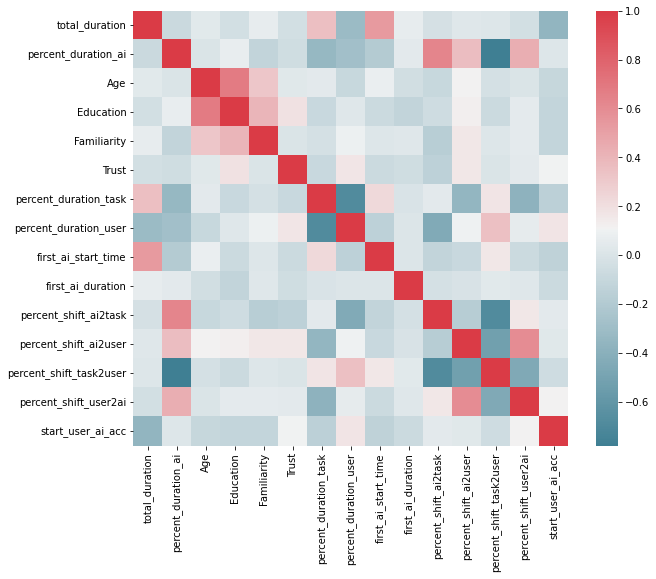

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_error, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

test_features = total_features[["total_duration", "percent_duration_ai", 
                                #"survey_reliance", "final_user_ai_acc","survey_agreement", "survey_trust", "survey_confidence", 
                                "Age", "Gender", "Education", 
                                "Familiarity", "Trust", 
                                "percent_duration_task", "percent_duration_user", 
                                "first_ai_start_time", "first_ai_duration", 
                                "percent_shift_ai2task", "percent_shift_ai2user", 
                                "percent_shift_task2user", "percent_shift_task2ai", 
                                "percent_shift_user2ai", "percent_shift_user2task", 
                                "percent_shift_2task", "percent_shift_2ai", "percent_shift_2user", 
                                #"final_user_truth_acc", "ai_truth_acc", #"start_user_truth_acc", 
                                "start_user_ai_acc", "Orientation", 
                                #"acc_improvement", "similarity_improvement"
                                ]]
test_features.loc[total_features['Gender'] == 'male', 'Gender'] = 0
test_features.loc[total_features['Gender'] == 'female', 'Gender'] = 1
test_features.loc[total_features['Orientation'] == 'bottom', 'Orientation'] = 0
test_features.loc[total_features['Orientation'] == 'top', 'Orientation'] = 1

drops = remove_collinear_features(test_features, 0.8)
test_features = test_features.drop(columns=drops)

# run correlation matrix and plot
f, ax = plt.subplots(figsize=(10, 8))
corr = test_features.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

X = test_features
y = total_features[["final_user_ai_acc"]]

X_scaler = StandardScaler().fit(X)
y_scaler = StandardScaler().fit(y)
X_scaled = X_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.33, random_state=42)

linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)
y_pred = linear_regression.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred)
y_test = y_scaler.inverse_transform(y_test)
r2 = r2_score(y_true=y_test,y_pred=y_pred)
print("r2 score:",r2)

mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
#squared True returns MSE value, False returns RMSE value.
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) #default=True
rmse = mean_squared_error(y_true=y_test,y_pred=y_pred,squared=False)
  
print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)

##linear regression to predict percent of gaze duration in ai

In [112]:
test_features = total_features[["total_duration", #"percent_duration_ai", 
                                #"survey_reliance", "final_user_ai_acc","survey_agreement", "survey_trust", "survey_confidence", 
                                "Age", "Gender", "Education", 
                                "Familiarity", "Trust", 
                                "percent_duration_task", #"percent_duration_user", 
                                "first_ai_start_time", "first_ai_duration", 
                                "percent_shift_ai2task", "percent_shift_ai2user", 
                                "percent_shift_task2user", "percent_shift_task2ai", 
                                "percent_shift_user2ai", "percent_shift_user2task", 
                                "percent_shift_2task", "percent_shift_2ai", "percent_shift_2user", 
                                #"final_user_truth_acc", "ai_truth_acc", #"start_user_truth_acc", 
                                "start_user_ai_acc", "Orientation", 
                                #"acc_improvement", "similarity_improvement"
                                ]]
test_features.loc[total_features['Gender'] == 'male', 'Gender'] = 0
test_features.loc[total_features['Gender'] == 'female', 'Gender'] = 1
test_features.loc[total_features['Orientation'] == 'bottom', 'Orientation'] = 0
test_features.loc[total_features['Orientation'] == 'top', 'Orientation'] = 1

drops = remove_collinear_features(test_features, 0.8)
test_features = test_features.drop(columns=drops)

X = test_features
y = total_features[["percent_duration_ai"]]

X_scaler = StandardScaler().fit(X)
y_scaler = StandardScaler().fit(y)
X_scaled = X_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.33, random_state=42)

linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)
y_pred = linear_regression.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred)
y_test = y_scaler.inverse_transform(y_test)
r2 = r2_score(y_true=y_test,y_pred=y_pred)
print("r2 score:",r2)

mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
#squared True returns MSE value, False returns RMSE value.
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) #default=True
rmse = mean_squared_error(y_true=y_test,y_pred=y_pred,squared=False)
  
print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)

percent_shift_task2ai | percent_shift_ai2task | 0.81
percent_shift_user2task | percent_shift_ai2task | 0.81
percent_shift_user2task | percent_shift_task2user | 0.82
percent_shift_2task | percent_shift_user2ai | 0.83
percent_shift_2ai | percent_shift_task2user | 0.93
percent_shift_2ai | percent_shift_user2task | 0.95
percent_shift_2user | percent_shift_ai2task | 0.93
percent_shift_2user | percent_shift_task2ai | 0.9
r2 score: 0.730352832367545
MAE: 0.023608804770432045
MSE: 0.0010844407192598803
RMSE: 0.03293084753327616


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


##ordinal regression to predict survey reliance

In [113]:
!pip install mord

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [114]:
#import ordinal regression code
import sys
sys.path.insert(0,'/content/drive/MyDrive/Ordinal_Classifier/')
import Ordinal as OC
#import a different ordinal regression module
import mord as m

test_features = total_features[[#total_duration", 
                                "percent_duration_ai", 
                                #"survey_reliance", "final_user_ai_acc","survey_agreement", "survey_trust", "survey_confidence", 
                                "Age", "Gender", "Education", 
                                "Familiarity", "Trust", 
                                "percent_duration_task", "percent_duration_user", 
                                "first_ai_start_time", "first_ai_duration", 
                                "percent_shift_ai2task", "percent_shift_ai2user", 
                                "percent_shift_task2user", "percent_shift_task2ai", 
                                "percent_shift_user2ai", "percent_shift_user2task", 
                                "percent_shift_2task", "percent_shift_2ai", "percent_shift_2user", 
                                #"final_user_truth_acc", "ai_truth_acc", 
                                "start_user_ai_acc", 
                                #"start_user_truth_acc", 
                                "Orientation", 
                                #"acc_improvement", "similarity_improvement"
                                ]]
test_features.loc[total_features['Gender'] == 'male', 'Gender'] = 0
test_features.loc[total_features['Gender'] == 'female', 'Gender'] = 1
test_features.loc[total_features['Orientation'] == 'bottom', 'Orientation'] = 0
test_features.loc[total_features['Orientation'] == 'top', 'Orientation'] = 1

drops = remove_collinear_features(test_features, 0.8)
test_features = test_features.drop(columns=drops)

X = test_features
y = total_features[["survey_reliance"]]

X_scaler = StandardScaler().fit(X)
X_scaled = X_scaler.fit_transform(X)
y_scaled = y

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.33, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

c = m.OrdinalRidge()
c.fit(X_train, y_train)

od = OC.OrdinalClassifier(LogisticRegression())
od.fit(X_train, y_train)

y_pred = od.predict(X_test)

accuracy = classification_report(y_test, y_pred)
print(accuracy)
r2 = r2_score(y_true=y_test,y_pred=y_pred)
print("r2 score:",r2)

mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
#squared True returns MSE value, False returns RMSE value.
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) #default=True
rmse = mean_squared_error(y_true=y_test,y_pred=y_pred,squared=False)

print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)

percent_shift_task2ai | percent_shift_ai2task | 0.81
percent_shift_user2task | percent_shift_ai2task | 0.81
percent_shift_user2task | percent_shift_task2user | 0.82
percent_shift_2task | percent_shift_user2ai | 0.83
percent_shift_2ai | percent_shift_task2user | 0.93
percent_shift_2ai | percent_shift_user2task | 0.95
percent_shift_2user | percent_shift_ai2task | 0.93
percent_shift_2user | percent_shift_task2ai | 0.9
              precision    recall  f1-score   support

           1       0.54      0.32      0.40        22
           2       0.41      0.69      0.52        35
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         3
           5       0.33      0.20      0.25        15
           6       0.25      0.50      0.33        14
           7       0.67      0.14      0.24        14

    accuracy                           0.38       113
   macro avg       0.31      0.26      0.25       113
weighted avg       0.39      0.38      

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: Dat

(array([13., 58.,  2.,  0.,  9., 28.,  3.]),
 array([1.        , 1.85714286, 2.71428571, 3.57142857, 4.42857143,
        5.28571429, 6.14285714, 7.        ]),
 <a list of 7 Patch objects>)

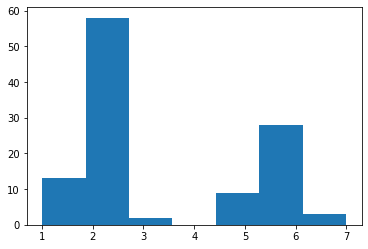

In [115]:
plt.hist(y_pred, bins=7)

(array([22., 35., 10.,  3., 15., 14., 14.]),
 array([1.        , 1.85714286, 2.71428571, 3.57142857, 4.42857143,
        5.28571429, 6.14285714, 7.        ]),
 <a list of 7 Patch objects>)

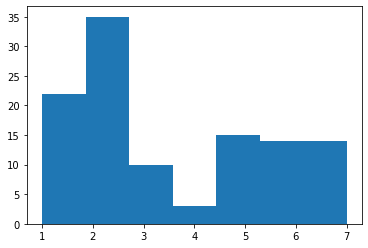

In [116]:
plt.hist(y_test.T, bins=7)

#predicting using 50%/65%/75%/85% time data

**add new features depending on time**

In [117]:
new_features = percent_duration_ai.merge(total_features, how='inner', on=['User id', 'round'])
new_features['percent_duration_ai']=new_features['percent duration']
new_features = new_features.drop(columns=['percent duration'])

new_features = percent_duration_task.merge(new_features, how='inner', on=['User id', 'round'])
new_features['percent_duration_task']=new_features['percent duration']
new_features = new_features.drop(columns=['percent duration'])

new_features = percent_duration_user.merge(new_features, how='inner', on=['User id', 'round'])
new_features['percent_duration_user']=new_features['percent duration']
new_features = new_features.drop(columns=['percent duration'])

In [118]:
new_features = percent_shift_ai2task.merge(new_features, how='inner', on=['User id', 'round'])
new_features['percent_shift_ai2task']=new_features['percent_shift']
new_features = new_features.drop(columns=['percent_shift'])

new_features = percent_shift_ai2user.merge(new_features, how='inner', on=['User id', 'round'])
new_features['percent_shift_ai2user']=new_features['percent_shift']
new_features = new_features.drop(columns=['percent_shift'])

new_features = percent_shift_user2task.merge(new_features, how='inner', on=['User id', 'round'])
new_features['percent_shift_user2task']=new_features['percent_shift']
new_features = new_features.drop(columns=['percent_shift'])

new_features = percent_shift_user2ai.merge(new_features, how='inner', on=['User id', 'round'])
new_features['percent_shift_user2ai']=new_features['percent_shift']
new_features = new_features.drop(columns=['percent_shift'])

new_features = percent_shift_task2ai.merge(new_features, how='inner', on=['User id', 'round'])
new_features['percent_shift_task2ai']=new_features['percent_shift']
new_features = new_features.drop(columns=['percent_shift'])

new_features = percent_shift_task2user.merge(new_features, how='inner', on=['User id', 'round'])
new_features['percent_shift_task2user']=new_features['percent_shift']
new_features = new_features.drop(columns=['percent_shift'])

In [119]:
new_features = percent_shift_2task.merge(new_features, how='inner', on=['User id', 'round'])
new_features['percent_shift_2task']=new_features['percent_shift']
new_features = new_features.drop(columns=['percent_shift'])

new_features = percent_shift_2user.merge(new_features, how='inner', on=['User id', 'round'])
new_features['percent_shift_2user']=new_features['percent_shift']
new_features = new_features.drop(columns=['percent_shift'])

new_features = percent_shift_2ai.merge(new_features, how='inner', on=['User id', 'round'])
new_features['percent_shift_2ai']=new_features['percent_shift']
new_features = new_features.drop(columns=['percent_shift'])

In [120]:
new_features

,User id,round,Unnamed: 0,total_duration,percent_duration_ai,total_duration_on_ai,Id,Round,survey_agreement,survey_reliance,...,count_2ai,count_2user,final_user_ai_acc,final_user_truth_acc,ai_truth_acc,start_user_ai_acc,start_user_truth_acc,Orientation,acc_improvement,similarity_improvement
0,1,1,0,42,0.165444,2.73363,1,1,6,5,...,4,6,1.0000,1.0000,1.0000,0.833333,0.833333,top,0.166667,0.166667
1,1,2,2,334,0.077609,6.38815,2,2,1,1,...,12,82,0.3750,0.3750,0.9375,0.750000,0.750000,bottom,-0.375000,-0.375000
2,1,3,3,47,0.269043,5.09594,3,3,6,6,...,8,7,1.0000,0.9375,0.9375,1.000000,0.916667,top,0.020833,0.000000
3,1,4,4,63,0.181849,2.92737,4,4,1,1,...,3,17,0.3750,0.3750,1.0000,0.666667,0.666667,bottom,-0.291667,-0.291667
4,1,5,5,36,0.226119,2.79822,5,5,7,7,...,7,10,1.0000,1.0000,1.0000,0.916667,0.916667,top,0.083333,0.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,48,6,338,47,0.059462,3.41316,456,6,6,6,...,4,15,1.0000,1.0000,1.0000,0.750000,0.750000,bottom,0.250000,0.250000
338,48,7,339,48,0.081409,1.22974,457,7,2,2,...,3,17,0.9375,1.0000,0.9375,0.833333,0.916667,top,0.083333,0.104167
339,48,8,340,39,0.101964,2.94226,458,8,2,2,...,5,10,0.9375,1.0000,0.9375,0.833333,0.916667,bottom,0.083333,0.104167
340,48,9,341,35,0.000000,1.39295,459,9,6,2,...,3,14,1.0000,1.0000,1.0000,0.916667,0.916667,top,0.083333,0.083333


In [121]:
total_features

,Unnamed: 0,User id,round,total_duration,percent_duration_ai,total_duration_on_ai,Id,Round,survey_agreement,survey_reliance,...,count_2ai,count_2user,final_user_ai_acc,final_user_truth_acc,ai_truth_acc,start_user_ai_acc,start_user_truth_acc,Orientation,acc_improvement,similarity_improvement
0,0,1,1,42,0.185714,2.73363,1,1,6,5,...,4,6,1.0000,1.0000,1.0000,0.833333,0.833333,top,0.166667,0.166667
1,2,1,2,334,0.024003,6.38815,2,2,1,1,...,12,82,0.3750,0.3750,0.9375,0.750000,0.750000,bottom,-0.375000,-0.375000
2,3,1,3,47,0.332952,5.09594,3,3,6,6,...,8,7,1.0000,0.9375,0.9375,1.000000,0.916667,top,0.020833,0.000000
3,4,1,4,63,0.076400,2.92737,4,4,1,1,...,3,17,0.3750,0.3750,1.0000,0.666667,0.666667,bottom,-0.291667,-0.291667
4,5,1,5,36,0.201638,2.79822,5,5,7,7,...,7,10,1.0000,1.0000,1.0000,0.916667,0.916667,top,0.083333,0.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,338,48,6,47,0.130746,3.41316,456,6,6,6,...,4,15,1.0000,1.0000,1.0000,0.750000,0.750000,bottom,0.250000,0.250000
338,339,48,7,48,0.040987,1.22974,457,7,2,2,...,3,17,0.9375,1.0000,0.9375,0.833333,0.916667,top,0.083333,0.104167
339,340,48,8,39,0.153503,2.94226,458,8,2,2,...,5,10,0.9375,1.0000,0.9375,0.833333,0.916667,bottom,0.083333,0.104167
340,341,48,9,35,0.074685,1.39295,459,9,6,2,...,3,14,1.0000,1.0000,1.0000,0.916667,0.916667,top,0.083333,0.083333


##linear regression to predict final user ai agreement

In [122]:
test_new_features = new_features[[#"total_duration", 
                                  "percent_duration_ai", 
                                #"survey_reliance", "final_user_ai_acc","survey_agreement", "survey_trust", "survey_confidence", 
                                "Age", "Gender", "Education", 
                                "Familiarity", "Trust", 
                                "percent_duration_task", "percent_duration_user", 
                                "first_ai_start_time", "first_ai_duration", 
                                "percent_shift_ai2task", "percent_shift_ai2user", 
                                "percent_shift_task2user", "percent_shift_task2ai", 
                                "percent_shift_user2ai", "percent_shift_user2task", 
                                "percent_shift_2task", "percent_shift_2ai", "percent_shift_2user", 
                                #"final_user_truth_acc", "ai_truth_acc", 
                                "start_user_ai_acc", 
                                #"start_user_truth_acc", 
                                "Orientation", 
                                #"acc_improvement", "similarity_improvement"
                                ]]
test_new_features.loc[new_features['Gender'] == 'male', 'Gender'] = 0
test_new_features.loc[new_features['Gender'] == 'female', 'Gender'] = 1
test_new_features.loc[new_features['Orientation'] == 'bottom', 'Orientation'] = 0
test_new_features.loc[new_features['Orientation'] == 'top', 'Orientation'] = 1

drops = remove_collinear_features(test_new_features, 0.8)
test_new_features = test_new_features.drop(columns=drops)

X = test_new_features
y = total_features[["final_user_ai_acc"]]

X_scaler = StandardScaler().fit(X)
y_scaler = StandardScaler().fit(y)
X_scaled = X_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.33, random_state=42)

linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)
y_pred = linear_regression.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred)
y_test = y_scaler.inverse_transform(y_test)
r2 = r2_score(y_true=y_test,y_pred=y_pred)
print("r2 score:",r2)

mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
#squared True returns MSE value, False returns RMSE value.
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) #default=True
rmse = mean_squared_error(y_true=y_test,y_pred=y_pred,squared=False)
  
print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)

percent_shift_task2user | percent_duration_ai | 0.86
percent_shift_task2ai | percent_shift_ai2task | 0.83
percent_shift_user2task | percent_duration_ai | 0.87
percent_shift_2ai | percent_duration_ai | 0.92
percent_shift_2ai | percent_shift_task2user | 0.9
percent_shift_2ai | percent_shift_user2task | 0.94
percent_shift_2user | percent_shift_ai2task | 0.87
percent_shift_2user | percent_shift_task2user | 0.82
percent_shift_2user | percent_shift_task2ai | 0.84
r2 score: 0.38271455116922093
MAE: 0.14590577353652673
MSE: 0.03572699971797248
RMSE: 0.18901587160334574


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


##linear regression to predict percent gaze duration on ai

In [123]:
test_new_features = new_features[["percent_duration_ai", 
                                #"survey_reliance", "final_user_ai_acc","survey_agreement", "survey_trust", "survey_confidence", 
                                "Age", "Gender", "Education", "Familiarity", "Trust", 
                                "percent_duration_task", "percent_duration_user", 
                                "first_ai_start_time", "first_ai_duration", 
                                "percent_shift_ai2task", "percent_shift_ai2user", 
                                "percent_shift_task2user", "percent_shift_task2ai", 
                                "percent_shift_user2ai", "percent_shift_user2task", 
                                "percent_shift_2task", "percent_shift_2ai", "percent_shift_2user", 
                                #"final_user_truth_acc", "ai_truth_acc", 
                                "start_user_ai_acc", 
                                #"start_user_truth_acc", 
                                "Orientation", 
                                #"acc_improvement", "similarity_improvement"
                                ]]
test_new_features.loc[new_features['Gender'] == 'male', 'Gender'] = 0
test_new_features.loc[new_features['Gender'] == 'female', 'Gender'] = 1
test_new_features.loc[new_features['Orientation'] == 'bottom', 'Orientation'] = 0
test_new_features.loc[new_features['Orientation'] == 'top', 'Orientation'] = 1

X_new = test_new_features
y_new = total_features[["percent_duration_ai"]]

X_scaler = StandardScaler().fit(X_new)
y_scaler = StandardScaler().fit(y_new)
X_scaled_new = X_scaler.fit_transform(X_new)
y_scaled_new = y_scaler.fit_transform(y_new)

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_scaled_new, y_scaled_new, test_size=0.33, random_state=42)

linear_regression = LinearRegression()
linear_regression.fit(X_train_new, y_train_new)

y_pred_new = linear_regression.predict(X_test_new)
y_pred_new = y_scaler.inverse_transform(y_pred_new)
y_test_new = y_scaler.inverse_transform(y_test_new)
r2 = r2_score(y_true=y_test_new,y_pred=y_pred_new)
print("r2 score:",r2)

mae = mean_absolute_error(y_true=y_test_new,y_pred=y_pred_new)
#squared True returns MSE value, False returns RMSE value.
mse = mean_squared_error(y_true=y_test_new,y_pred=y_pred_new) #default=True
rmse = mean_squared_error(y_true=y_test_new,y_pred=y_pred_new,squared=False)
  
print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)

r2 score: 0.5984080209429148
MAE: 0.03125597698302238
MSE: 0.0016150835124338488
RMSE: 0.04018810162764408


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


##ordinal regression to predict survey reliance


In [124]:
test_new_features = new_features[[#"total_duration", 
                                  "percent_duration_ai", 
                                #"survey_reliance", "final_user_ai_acc","survey_agreement", "survey_trust", "survey_confidence", 
                                "Age", "Gender", "Education", 
                                "Familiarity", "Trust", 
                                "percent_duration_task", "percent_duration_user", 
                                "first_ai_start_time", "first_ai_duration", 
                                "percent_shift_ai2task", "percent_shift_ai2user", 
                                "percent_shift_task2user", "percent_shift_task2ai", 
                                "percent_shift_user2ai", "percent_shift_user2task", 
                                "percent_shift_2task", "percent_shift_2ai", "percent_shift_2user", 
                                #"final_user_truth_acc", "ai_truth_acc", 
                                "start_user_ai_acc", 
                                #"start_user_truth_acc", 
                                "Orientation", 
                                #"acc_improvement", "similarity_improvement"
                                ]]
test_new_features.loc[new_features['Gender'] == 'male', 'Gender'] = 0
test_new_features.loc[new_features['Gender'] == 'female', 'Gender'] = 1
test_new_features.loc[new_features['Orientation'] == 'bottom', 'Orientation'] = 0
test_new_features.loc[new_features['Orientation'] == 'top', 'Orientation'] = 1

drops = remove_collinear_features(test_new_features, 0.8)
test_new_features = test_new_features.drop(columns=drops)

X = test_new_features
y = total_features[["survey_reliance"]]

X_scaler = StandardScaler().fit(X)
y_scaler = StandardScaler().fit(y)
X_scaled = X_scaler.fit_transform(X)
#y_scaled = y_scaler.fit_transform(y)
y_scaled = y

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.33, random_state=42)

od = OC.OrdinalClassifier(LogisticRegression())
od.fit(X_train, y_train)

c = m.OrdinalRidge()
c.fit(X_train, y_train)

y_pred = od.predict(X_test)

accuracy = classification_report(y_test, y_pred)
print(accuracy)
r2 = r2_score(y_true=y_test,y_pred=y_pred)
print("r2 score:",r2)

mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
#squared True returns MSE value, False returns RMSE value.
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) #default=True
rmse = mean_squared_error(y_true=y_test,y_pred=y_pred,squared=False)

print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


percent_shift_task2user | percent_duration_ai | 0.86


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

percent_shift_task2ai | percent_shift_ai2task | 0.83
percent_shift_user2task | percent_duration_ai | 0.87
percent_shift_2ai | percent_duration_ai | 0.92
percent_shift_2ai | percent_shift_task2user | 0.9
percent_shift_2ai | percent_shift_user2task | 0.94
percent_shift_2user | percent_shift_ai2task | 0.87
percent_shift_2user | percent_shift_task2user | 0.82
percent_shift_2user | percent_shift_task2ai | 0.84
              precision    recall  f1-score   support

           1       0.56      0.23      0.32        22
           2       0.41      0.69      0.52        35
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         3
           5       0.23      0.20      0.21        15
           6       0.18      0.36      0.24        14
           7       0.33      0.07      0.12        14

    accuracy                           0.34       113
   macro avg       0.24      0.22      0.20       113
weighted avg       0.33      0.34      0.30      

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([ 9., 58.,  2.,  0., 13., 28.,  3.]),
 array([1.        , 1.85714286, 2.71428571, 3.57142857, 4.42857143,
        5.28571429, 6.14285714, 7.        ]),
 <a list of 7 Patch objects>)

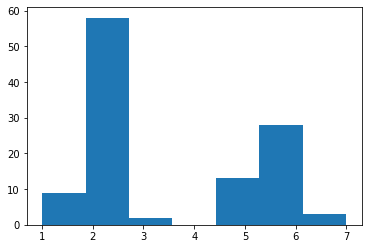

In [125]:
plt.hist(y_pred, bins=7)

(array([22., 35., 10.,  3., 15., 14., 14.]),
 array([1.        , 1.85714286, 2.71428571, 3.57142857, 4.42857143,
        5.28571429, 6.14285714, 7.        ]),
 <a list of 7 Patch objects>)

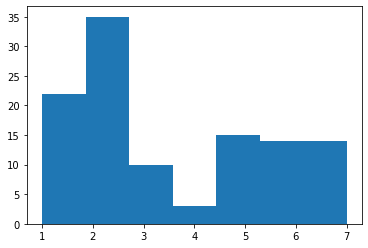

In [126]:
plt.hist(y_test.T, bins=7)